# The problem

Let $\Omega =  (-1,1)\times (-1,1)$, the problem is

---

$$
\begin{cases}
u_{xx}+u_{yy} = 0, & \qquad\text{for}\; (x,y)\in (-1,1)\times (-1,1),\\
u(x,y) = xy , &\qquad\text{for}\; (x,y)\in \partial \Omega
\end{cases}
$$ 

---

The exact solution is 

---

$$u(x,y) = xy $$

---

The Loss is

$$ L(\hat{u}) = \frac{1}{N^2}\sum_{j=1}^N\sum_{i=1}^N \Big(u_{xx} + u_{yy}\Big)^2$$

# Loading libraries

In [1]:
# Import libraries
import numpy as np
import math
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [2]:
import matplotlib.pyplot as plt

In [3]:
N = 32
xs = torch.linspace(-1, 1, steps=N, requires_grad=True)
ys = torch.linspace(-1, 1, steps=N, requires_grad=True)
x, y = torch.meshgrid(xs, ys, indexing='xy')
[step_x, step_y] = [2/(N-1),2/(N-1)]

# Gradient functions

In [4]:
def gradient(u, step_x, step_y):
    # all inputs are (n*n)-dim pytorch tensor
    [Nx, Ny] = list(u.size())
    u_x_tensor = 0*u.clone()
    for row in range(1, Ny-1):
        u_x_tensor[row, 1:-1] = (-u[row, 0:-2] + u[row, 2:])/(2*step_x)
    u_y_tensor = 0*u.clone()
    for col in range(1, Nx-1):
        u_y_tensor[1:-1, col] = (-u[0:-2, col] + u[2:, col])/(2*step_y)
    return [u_x_tensor, u_y_tensor]    

def abs_grad(u, step_x, step_y):
    [u_x, u_y] = gradient(u, step_x, step_y)
    return torch.sqrt(torch.square(u_x) + torch.square(u_y))

def Laplacian(u, step_x, step_y):
    [Nx, Ny] = list(u.size())
    u_xx = 0*u.clone()
    for row in range(1, Ny-1):
        u_xx[row, 1:-1] = (u[row, 0:-2] + u[row, 2:] - 2*u[row, 1:-1])/(step_x**2)
    u_yy = 0*u.clone()
    for col in range(1, Nx-1):
        u_yy[1:-1, col] = (u[0:-2, col] + u[2:, col] - 2*u[1:-1, col])/(step_y**2)
    return (u_xx + u_yy)

# Loss function

In [5]:
def Loss(u, xs, ys, eps, step_x, step_y):
    [Nx, Ny] = list(u.size())
    # all inputs are (n*n)-dim pytorch tensor

    loss = nn.MSELoss()
    zero_tensor = torch.zeros(Nx, Ny, dtype=torch.float32)
    l = Laplacian(u,step_x,step_y)
   
    result = loss(Laplacian(u,step_x,step_y), zero_tensor) 
    return result

# Model

In [6]:
def PDEsNet(input_size=2, output_size=1, k=15):
    model = nn.Sequential(
        nn.Linear(input_size, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, output_size),
        nn.Tanh(),
                      )
    return model
# module5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
# init.xavier_normal_(module5.weight)

# Pack and Unpack

In [7]:
def unpack_column(xs, ys, Nx, Ny):
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    # unpack_col = []
    for i in range(0, Nx):
        row_i = torch.stack([x[:,i],y[:,i]], dim=1)
        if i == 0:
            unpack_col = row_i
        else:    
            unpack_col = torch.vstack([unpack_col,row_i])
    return unpack_col        

In [8]:
def pack_column(u, Nx, Ny):
    return torch.transpose(u.reshape((Nx, Ny)), 0, 1)

# Plot functions

In [9]:
def draw_loss(iter, loss, title='Loss'):
    plt.plot(iter, loss, '-b', label='loss')
    ##############################################
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)
    # save image
    plt.savefig(title +".png")  # should before show method
    # show
    plt.show()

def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')
    ##############################################
    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.axis('off')
    
    # save image
    plt.savefig(title+".png")  # should before show method
    # show
    plt.show()

In [10]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    "Credit: Ben Moseley"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

def graph(x, y, u_hat):
    fig, ax = plt.subplots()
    ax = plt.axes(projection='3d')

    ax.set_ylabel('y')
    ax.set_xlabel('x')

    ax.set_zlim([0,1])

    # ax.grid(False)
    plt.axis('off')

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    X = x.detach().numpy()
    Y = y.detach().numpy()
    Z = u_hat.detach().numpy()

    ax.plot_surface(X, Y, Z,  
                    rstride=1, cstride=1,
                    cmap='winter', edgecolor='none')
    

# Training

In [11]:
[Nx, Ny] = [len(x), len(y)]

In [12]:
torch.manual_seed(111)
model = PDEsNet(input_size=2, output_size=1, k=8)
files = []

The running loss at 099 iteration is: 53.18058395385742
The running loss at 199 iteration is: 40.677406311035156
The running loss at 299 iteration is: 34.819427490234375
The running loss at 399 iteration is: 30.572654724121094
The running loss at 499 iteration is: 26.424179077148438


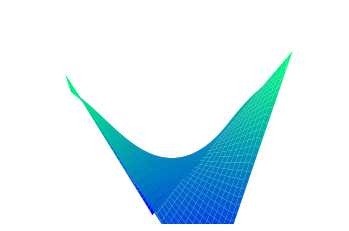

The running loss at 599 iteration is: 28.685653686523438
The running loss at 699 iteration is: 11.11290168762207
The running loss at 799 iteration is: 6.829702854156494
The running loss at 899 iteration is: 4.8102216720581055
The running loss at 999 iteration is: 3.8137705326080322


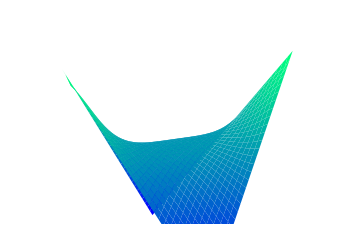

In [13]:
# torch.autograd.set_detect_anomaly(True)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
eps = 0.01
iter = []
loss_array = []
##############################################
num_e = 1000
for e in range(num_e):
    running_loss = 0
    optimizer.zero_grad() 
    ##############################################
    coordinates = unpack_column(xs, ys, Nx, Ny)
    u_hat_array = model(coordinates).clone() # need to not messed up the bakprop
    u_hat = pack_column(u_hat_array, Nx, Ny)
    # print(u_hat)

    # u_hat = 0*x*y
    # for i in range(1,Nx-1):
    #     for j in range(1, Ny-1):
    #         # print([xs[i], ys[j]])
    #         x_tensor = torch.tensor(np.array([xs[i].item(), ys[j].item()]), requires_grad= True)
    #         temp = model(x_tensor.float())
    #         u_hat[i, j] = temp

    # loss and backward
    u_star = torch.multiply(x,y)
    u_hat[ 0, :] = u_star[ 0, :]
    u_hat[-1, :] = u_star[-1, :]
    u_hat[ :, 0] = u_star[ :, 0]
    u_hat[ :,-1] = u_star[ :,-1]
    # u_hat[0, :] *= 0
    # u_hat[-1,:] *= 0
    # u_hat[:, 0] *= 0
    # u_hat[:,-1] *= 0
    loss = Loss(u_hat, xs, ys, eps, step_x, step_y)
   
    loss.backward()
    optimizer.step() 
    ########################################################################
    running_loss += loss.clone().item()   
    loss_array.append(running_loss)
    iter.append(e)
    ########################################################################
    if ((e+1) % 100 == 0):
        print(f"The running loss at {(e):03d} iteration is: {running_loss}")

        graph(x, y, u_hat)
        file = "nn_%.8e.png"%(e+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecollor='white') 
        files.append(file)

        if (e+1)%500 == 0:
            plt.show()
        else:
            plt.close("all")

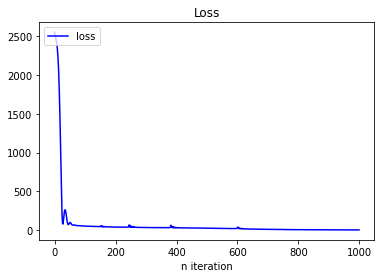

In [14]:
save_gif_PIL("nn.gif", files, fps=20, loop=0)
draw_loss(iter, loss_array, title='Loss')

# Plot

In [15]:
import webbrowser
webbrowser.open('/content/nn.gif')

False

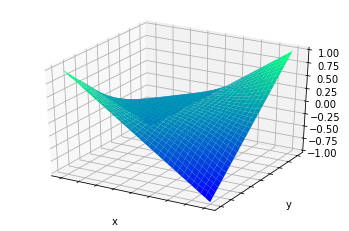

In [16]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

ax.set_ylabel('y')
ax.set_xlabel('x')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

X = x.detach().numpy()
Y = y.detach().numpy()
Z = u_hat.detach().numpy()
# ax.plot_surface(x.detach().numpy(), y.detach().numpy(), u_hat.detach().numpy())
ax.plot_surface(X, Y, Z,  
                rstride=1, cstride=1,
                cmap='winter', edgecolor='none')

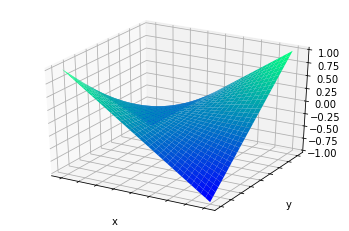

In [17]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

ax.set_ylabel('y')
ax.set_xlabel('x')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

X = x.detach().numpy()
Y = y.detach().numpy()
Z = u_star.detach().numpy()
# ax.plot_surface(x.detach().numpy(), y.detach().numpy(), u_hat.detach().numpy())
ax.plot_surface(X, Y, Z,  
                rstride=1, cstride=1,
                cmap='winter', edgecolor='none')

In [18]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Surface(z=Z, x=X, y=Y, colorscale="Reds", opacity=0.5)])
fig.update_layout(
    title='My title', 
    autosize=False,
    width=500, 
    height=500,
    margin=dict(l=65, r=50, b=65, t=90), 
    scene_aspectmode='cube'
)
fig.show()